In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
%matplotlib inline
import numpy as np # linear algebra
import pandas as pd # data processing
import matplotlib.pyplot as plt # graphs and charts
import pandas_profiling # generating Profile Report
from sklearn.model_selection import train_test_split
import numpy as np

import bq_helper # accessing bigQuery database

import sklearn
from sklearn.model_selection import train_test_split # data splitting
import statsmodels.api as sm
from sklearn import metrics
from sklearn.linear_model import LinearRegression # Linear model
from sklearn.metrics import mean_squared_error
import wordcloud
import random 
from flask import Flask, render_template, request, json
import json
import pandas as pd

# **Accessing the Dataset**
   * Accessing the required dataset from BigQuery
   
### About '*bq_helper*'
   * <p style='text-align: justify;'> bq_helper package simplifies common read-only tasks in BigQuery by dealing with object references and unpacking result objects into pandas dataframes.</p>
   * <p style='text-align: justify;'> It currently only works here on Kaggle as it does not have any handling for the BigQuery authorization functions that Kaggle handles behind the scenes. </p>
   * <p style='text-align: justify;'>bq_helper requires the creation of one BigQueryHelper object per dataset. Let's make one now. We'll need to pass it two arguments: </p>
      1) The name of the BigQuery project, which on Kaggle should always be bigquery-public-data  
      2) The name of the dataset, which can be found in the dataset description  

In [3]:
stackoverflow = bq_helper.BigQueryHelper("bigquery-public-data","stackoverflow")

Using Kaggle's public dataset BigQuery integration.


In [4]:
stackoverflow.list_tables()

['badges',
 'comments',
 'post_history',
 'post_links',
 'posts_answers',
 'posts_moderator_nomination',
 'posts_orphaned_tag_wiki',
 'posts_privilege_wiki',
 'posts_questions',
 'posts_tag_wiki',
 'posts_tag_wiki_excerpt',
 'posts_wiki_placeholder',
 'stackoverflow_posts',
 'tags',
 'users',
 'votes']

In [5]:
import re
#list_of_tags = stackoverflow.to_list('tags')
query1 = """select tags from `bigquery-public-data.stackoverflow.posts_questions` LIMIT 100000"""
df = stackoverflow.query_to_pandas(query1)
llist = df['tags'].to_list()
print(llist[0:10])
new_list = [i.split('|') for i in llist]
flat_list = []
for sublist in new_list:
    for item in sublist:
        flat_list.append(item)
    #new_list.append(i.split('|'))
print("=======================")
print(new_list[0:10])
print("++++++++++++++++")
print(flat_list[0:10])
#print(tags)

['android|sqlite|greendao', 'ruby-on-rails|selenium|capybara', 'c#|winapi|directshow|gdi|user32', 'java|android|regex|syntax-error', 'javascript|ajax|asp.net-mvc-4|charts', 'javascript|ckeditor|ckeditor4.x', 'c#|.net|wcf|soap|webmethod', 'java|eclipse|git|intellij-idea', 'axapta|microsoft-dynamics|dynamics-ax-2009', 'jquery|jquery-ui-layout']
[['android', 'sqlite', 'greendao'], ['ruby-on-rails', 'selenium', 'capybara'], ['c#', 'winapi', 'directshow', 'gdi', 'user32'], ['java', 'android', 'regex', 'syntax-error'], ['javascript', 'ajax', 'asp.net-mvc-4', 'charts'], ['javascript', 'ckeditor', 'ckeditor4.x'], ['c#', '.net', 'wcf', 'soap', 'webmethod'], ['java', 'eclipse', 'git', 'intellij-idea'], ['axapta', 'microsoft-dynamics', 'dynamics-ax-2009'], ['jquery', 'jquery-ui-layout']]
++++++++++++++++
['android', 'sqlite', 'greendao', 'ruby-on-rails', 'selenium', 'capybara', 'c#', 'winapi', 'directshow', 'gdi']


## Data Pre-processing :
* Removing irrelevant data
* Querying the year and the number of posts per year from the '*posts_questions*' table

# Current Trends:

## Total number of Posts Per year between 2008 and current year 2020

In [6]:
queryx = """select EXTRACT(year FROM creation_date) AS year, COUNT(*) AS posts 
        from `bigquery-public-data.stackoverflow.posts_questions`
        where extract(year from creation_date) >= 2008 and extract(year from creation_date) < 2021
        group by year
        order by year
        """

PostsCount = stackoverflow.query_to_pandas(queryx)
print(PostsCount)

    year    posts
0   2008    57924
1   2009   342540
2   2010   692208
3   2011  1192677
4   2012  1633858
5   2013  2046718
6   2014  2152753
7   2015  2206658
8   2016  2209585
9   2017  2125712
10  2018  1903069
11  2019  1886780
12  2020  1644173


## Common function for CURRENT TRENDS and COMPARATIVE ANALYSIS :

In [7]:
def CurrentTrends(dfall, labels = None, title="Current Trends", **kwargs):
    query1 = "select EXTRACT(year FROM creation_date) AS year, COUNT(id) as posts from `bigquery-public-data.stackoverflow.posts_questions` where extract(year from creation_date) >=2009 and extract(year from creation_date) < 2021 and tags like '%"
    query3 ="%' group by year order by year"
    df = []
    
    if labels==None:
        labels = dfall    #the keywords list
        
    l = len(dfall)
    ###### for every tag, execute the query separately
    for i in range(l):
        query2 = dfall[i]    # dfall = ['hadoop','spark','hive']
        query = query1+query2+query3
        Posts = stackoverflow.query_to_pandas(query)
        #Posts['posts']= Posts['posts']*100/PostsCount.posts
        pd.to_numeric(Posts['year'])
        Posts.rename(columns = {'posts':dfall[i]}, inplace = True) 
        df.append(Posts)
        

    trend = pd.DataFrame(df[0])
    trend = trend.set_index('year')
    #print(trend)
    
    
    if(l>1):
        for i in range(1,l):
            trend = pd.merge(trend, df[i], how='outer', on = 'year')
            trend = trend.set_index('year')
            trend = trend.fillna(0)
    #print("trend", trend)
    curr_trendsjson = trend.to_json(orient="index")
    
    #parsed = json.loads(curr_result1)
    #json.dumps(parsed, indent=4)
    #print(trend)
    
    trend.plot(kind='line')
    plt.xlabel('Year', fontsize=15)
    plt.ylabel('Number of Posts', fontsize=15)
    y_pos=[2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020]
    plt.xticks(y_pos,fontsize=8)
    plt.yticks(fontsize=8)
    plt.title(title)
    plt.legend(labels, loc=[1.0,0.5])
    plt.show()
    
    return curr_trendsjson
    
    

    

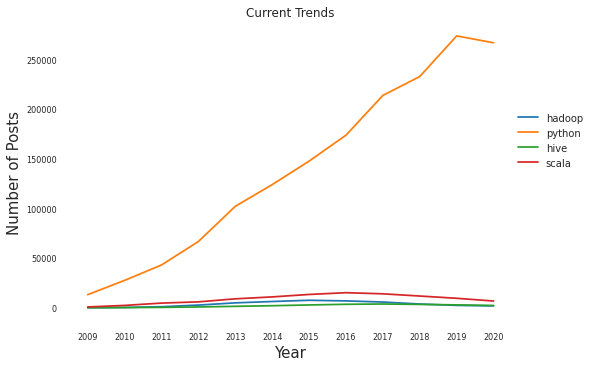

'{"2009":{"hadoop":71,"python":13212,"hive":97,"scala":826},"2010":{"hadoop":320,"python":27559,"hive":197,"scala":2381},"2011":{"hadoop":1063,"python":43065,"hive":420,"scala":4706},"2012":{"hadoop":2721,"python":66671,"hive":835,"scala":5952},"2013":{"hadoop":4946,"python":102053,"hive":1459,"scala":9003},"2014":{"hadoop":6309,"python":123878,"hive":2071,"scala":10941},"2015":{"hadoop":7548,"python":147526,"hive":2841,"scala":13405},"2016":{"hadoop":6915,"python":173607,"hive":3510,"scala":15175},"2017":{"hadoop":5775,"python":213610,"hive":3800,"scala":14039},"2018":{"hadoop":3764,"python":232584,"hive":3397,"scala":11813},"2019":{"hadoop":2415,"python":273458,"hive":2904,"scala":9545},"2020":{"hadoop":1894,"python":266561,"hive":2311,"scala":6799}}'

In [8]:
## For testing purposes: 
curr_trendsjson = CurrentTrends(['hadoop','python','hive','scala'])
curr_trendsjson      #json object for current trends

## Plot to highlight Number of Answered questions over the years (Current Trends)(for 1 keyword search only) : 

In [9]:
def Current_Answered(dfall, labels = None, title="Current Trends", **kwargs):
    #query1 = "select EXTRACT(year FROM creation_date) AS year, COUNT(id) as posts from `bigquery-public-data.stackoverflow.posts_questions` where extract(year from creation_date) >=2009 and extract(year from creation_date) < 2021 and tags like '%"
    query1 = "SELECT EXTRACT(YEAR FROM creation_date) AS year,COUNT(*) AS posts, ROUND(100 * SUM(IF(answer_count > 0, 1, 0)) / COUNT(*), 1) AS answered_q FROM `bigquery-public-data.stackoverflow.posts_questions` WHERE extract(year from creation_date) >=2009 and extract(year from creation_date) < 2021 and tags like '%"            
    query3 ="%' group by year order by year"
    df = []
    
    
    if labels==None:
        labels = dfall    #the keywords list
        
    l = len(dfall)
    ###### for every tag, execute the query separately
    for i in range(l):
        query2 = dfall[i]    # dfall = ['hadoop','spark','hive']
        query = query1+query2+query3
        Posts = stackoverflow.query_to_pandas(query)
        #print(Posts)
        #Posts['posts']= Posts['posts']*100/PostsCount.posts
        pd.to_numeric(Posts['year'])
        Posts.rename(columns = {'posts':dfall[i]}, inplace = True) 
        df.append(Posts)
        

    trend = pd.DataFrame(df[0])
    trend = trend.set_index('year')
     #print(trend)
    
    
    if(l>1):
        for i in range(1,l):
            trend = pd.merge(trend, df[i], how='outer', on = 'year')
            trend = trend.set_index('year')
            trend = trend.fillna(0)
    #print(trend)
    curr_trendsjson = trend.to_json(orient="index")
    
#     parsed = json.loads(curr_result1)
#     json.dumps(parsed, indent=4)
#     print(trend)
    
    trend.plot(kind='line')
    plt.xlabel('Year', fontsize=15)
    plt.ylabel('Posts %', fontsize=15)
    y_pos=[2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020]
    plt.xticks(y_pos,fontsize=8)
    plt.yticks(fontsize=8)
    plt.title(title)
    plt.legend(labels, loc=[1.0,0.5])
    plt.show()

    return curr_trendsjson
    
    

    

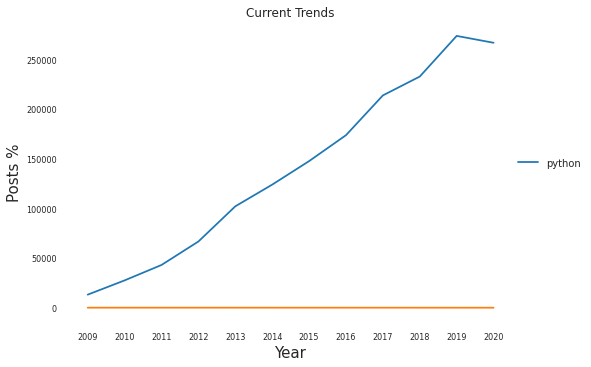

'{"2009":{"python":13212,"answered_q":99.8},"2010":{"python":27559,"answered_q":99.5},"2011":{"python":43065,"answered_q":98.4},"2012":{"python":66671,"answered_q":96.7},"2013":{"python":102053,"answered_q":93.9},"2014":{"python":123878,"answered_q":90.9},"2015":{"python":147526,"answered_q":88.8},"2016":{"python":173607,"answered_q":86.9},"2017":{"python":213610,"answered_q":85.2},"2018":{"python":232584,"answered_q":83.1},"2019":{"python":273458,"answered_q":78.3},"2020":{"python":266561,"answered_q":68.0}}'

In [10]:
answered_json = Current_Answered(['python'])
answered_json

## Current Trends for merging with future trend :

In [11]:
def CurrentTrends_merge(dfall, labels = None, title="Current Trends", **kwargs):
    
    query1 = "select EXTRACT(year FROM creation_date) AS year, COUNT(id) as posts from `bigquery-public-data.stackoverflow.posts_questions` where extract(year from creation_date) >=2009 and extract(year from creation_date) < 2021 and tags like '%"
    query3 ="%' group by year order by year"
    df = []
    
    if labels==None:
        labels = dfall    #the keywords list
        
    l = len(dfall)
    ###### for every tag, execute the query separately
    for i in range(l):
        query2 = dfall[i]    # dfall = ['hadoop','spark','hive']
        query = query1+query2+query3
        Posts = stackoverflow.query_to_pandas(query)
        #Posts['posts']= Posts['posts']*100/PostsCount.posts
        pd.to_numeric(Posts['year'])
        Posts.rename(columns = {'posts':dfall[i]}, inplace = True) 
        df.append(Posts)
        
    trend = pd.DataFrame(df[0])
    trend = trend.set_index('year')
    
    if(l>1):
        for i in range(1,l):
            trend = pd.merge(trend, df[i], how='outer', on = 'year')
            trend = trend.set_index('year')
            trend = trend.fillna(0)
    
    return trend


In [12]:
## For testing Purposes :
curr_trendmerge = CurrentTrends_merge(['html','kubernetes'])
curr_trendmerge

,html,kubernetes
year,,
2009,10680,0.0
2010,25699,0.0
2011,52182,0.0
2012,81902,0.0
2013,121666,1.0
2014,140520,45.0
2015,139073,810.0
2016,133127,1790.0
2017,123142,3373.0


## Future Trends :

In [13]:
def FutureTrends(dfall, labels = None, title="Trends in Technologies in ", **kwargs):

    #plt.figure(figsize=(20,10))
    
    query1 = "select EXTRACT(year FROM creation_date) AS year, COUNT(id) as posts from `bigquery-public-data.stackoverflow.posts_questions` where extract(year from creation_date) >=2009 and extract(year from creation_date) < 2021 and tags like '%"
    query3 ="%' group by year order by year"
    df = []
    new = []
    l = len(dfall)
    years = [2021, 2022, 2023]    
    
    if (labels==None):
        labels = dfall
        
    for i in range(l):
        query2 = dfall[i]
        query = query1+query2+query3
        Posts = stackoverflow.query_to_pandas(query)
        #Posts['posts']= Posts['posts']*100/PostsCount.posts
        pd.to_numeric(Posts['year'])
        
        X_train=Posts['year'].values.reshape(-1,1)
        y_train=Posts['posts'].values.reshape(-1,1)
        reg=LinearRegression()
        
        X_test = [[2021], [2022], [2023]]     #hardcoded 3 years
        reg.fit(X_train,y_train)
        predictions = reg.predict(X_test)
        
        #
        for j in range(len(predictions)):
            predictions[j][0] = round(predictions[j][0])
            if predictions[j][0] < 0:
                predictions[j][0] = 0.001
            
        #print(predictions)
       
   
        dummy = pd.DataFrame(columns = ['year', labels[i]])
        dummy['year']= years
        dummy[labels[i]] = predictions
       
   
        new.append(dummy)
        #predictions.reshape((1,len(X_test))
    
    trendfuture = pd.DataFrame(new[0])            #first keyword data + predictions
    trendfuture = trendfuture.set_index('year')
    
    if(l>1):                  # if more than 1 keyword
        for i in range(1,l):
            #print()
            trendfuture = pd.merge(trendfuture, new[i], how='outer', on = 'year')
            trendfuture = trendfuture.set_index('year')
    print(trendfuture)
    
    
    curr_trendmerge = CurrentTrends_merge(labels)
    

    #print(curr_trendmerge)
    final = pd.concat([curr_trendmerge, trendfuture])
    print(final)
    
    final.plot(kind='line')
    plt.xlabel('Year', fontsize=15)
    plt.ylabel('Number of Posts', fontsize=15)
    y_pos=[2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023]
    plt.xticks(y_pos,fontsize=9)
    plt.yticks(fontsize=9)
    plt.title(title)
    plt.legend(labels, loc=[1.0,0.5])
    plt.show()

## Converting to JSON :

    future_trendsjson = final.to_json(orient="index")
    
    #parsed = json.loads(curr_result1)
    #json.dumps(parsed, indent=4)
    
    return future_trendsjson
   

          html  kubernetes       php     ruby
year                                         
2021  130514.0     11713.0  136614.0  29998.0
2022  136718.0     13385.0  139445.0  28666.0
2023  142923.0     15058.0  142277.0  27334.0
          html  kubernetes       php     ruby
year                                         
2009   10680.0         0.0   20971.0  10169.0
2010   25699.0         0.0   53352.0  24513.0
2011   52182.0         0.0   99739.0  47715.0
2012   81902.0         0.0  137695.0  59245.0
2013  121666.0         1.0  174384.0  66538.0
2014  140520.0        45.0  185421.0  62022.0
2015  139073.0       810.0  177565.0  56670.0
2016  133127.0      1790.0  167537.0  48458.0
2017  123142.0      3373.0  146975.0  33569.0
2018   94010.0      7490.0  107494.0  23337.0
2019   85491.0     10474.0   86323.0  18917.0
2020   74719.0      9528.0   61044.0  12717.0
2021  130514.0     11713.0  136614.0  29998.0
2022  136718.0     13385.0  139445.0  28666.0
2023  142923.0     15058.0  142277

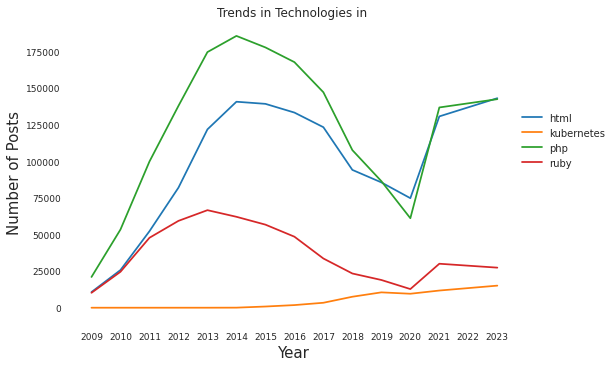

'{"2009":{"html":10680.0,"kubernetes":0.0,"php":20971.0,"ruby":10169.0},"2010":{"html":25699.0,"kubernetes":0.0,"php":53352.0,"ruby":24513.0},"2011":{"html":52182.0,"kubernetes":0.0,"php":99739.0,"ruby":47715.0},"2012":{"html":81902.0,"kubernetes":0.0,"php":137695.0,"ruby":59245.0},"2013":{"html":121666.0,"kubernetes":1.0,"php":174384.0,"ruby":66538.0},"2014":{"html":140520.0,"kubernetes":45.0,"php":185421.0,"ruby":62022.0},"2015":{"html":139073.0,"kubernetes":810.0,"php":177565.0,"ruby":56670.0},"2016":{"html":133127.0,"kubernetes":1790.0,"php":167537.0,"ruby":48458.0},"2017":{"html":123142.0,"kubernetes":3373.0,"php":146975.0,"ruby":33569.0},"2018":{"html":94010.0,"kubernetes":7490.0,"php":107494.0,"ruby":23337.0},"2019":{"html":85491.0,"kubernetes":10474.0,"php":86323.0,"ruby":18917.0},"2020":{"html":74719.0,"kubernetes":9528.0,"php":61044.0,"ruby":12717.0},"2021":{"html":130514.0,"kubernetes":11713.0,"php":136614.0,"ruby":29998.0},"2022":{"html":136718.0,"kubernetes":13385.0,"php":

In [14]:
future = (FutureTrends(['html','kubernetes', 'php','ruby']))
future

## Number of tags per day :

In [18]:
#stackoverflow.head("posts_questions")

query1 = "select EXTRACT(date FROM creation_date) AS Date, count(id) AS PostsCnt from `bigquery-public-data.stackoverflow.posts_questions` where extract(year from creation_date) >=2009 and extract(year from creation_date) < 2021 group by date order by date"
#query3 = "%' group by year order by year"
timeseries_python = stackoverflow.query_to_pandas(query1)
timeseries_python

final.plot(kind='line')
plt.xlabel('Year', fontsize=15)
plt.ylabel('Number of Posts', fontsize=15)
y_pos=[2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020]
plt.xticks(y_pos,fontsize=9)
plt.yticks(fontsize=9) 
plt.title(title)
plt.legend(labels, loc=[1.0,0.5])
plt.show()

,Date,PostsCnt
0,2009-01-01,192
1,2009-01-02,378
2,2009-01-03,232
3,2009-01-04,280
4,2009-01-05,472
...,...,...
4262,2020-09-02,8089
4263,2020-09-03,8289
4264,2020-09-04,7378
4265,2020-09-05,4799


# *****Use these Tags for DropDown search bar in UI ******

## Top 25 tags till 2020 :

In [19]:
query_toptags = '''select tag_name, count
from `bigquery-public-data.stackoverflow.tags`
where 
order by count desc
limit 25
'''
toptags = stackoverflow.query_to_pandas(query_toptags)
toptags

,tag_name,count
0,javascript,2081682
1,java,1709763
2,python,1528649
3,c#,1433486
4,php,1369355
5,android,1296865
6,html,1019597
7,jquery,996292
8,c++,690400
9,css,682048


# Use below function for email notifications part : Top trending tags from 1st Jan 2020 to 6th September 2020 (last date of updation..  next quarterly update in December)


In [33]:
def top_tags():
    
    query_testing = """SELECT tag, COUNT(*) c
    FROM (
      SELECT SPLIT(tags, '|') tags
      FROM `bigquery-public-data.stackoverflow.posts_questions` a
      WHERE EXTRACT(DATE FROM creation_date)>= '2020-01-01' AND EXTRACT(DATE FROM creation_date)<= '2020-09-06'
    ), UNNEST(tags) tag
    GROUP BY 1
    ORDER BY 2 DESC
    LIMIT 10
    """

    query_toptags = stackoverflow.query_to_pandas(query_testing)
    toptags_json = query_toptags.to_json(orient = 'index')
    return toptags_json

In [34]:
toptags = top_tags()
toptags

'{"0":{"tag":"python","c":235787},"1":{"tag":"javascript","c":179535},"2":{"tag":"java","c":106318},"3":{"tag":"c#","c":74812},"4":{"tag":"android","c":72644},"5":{"tag":"reactjs","c":71179},"6":{"tag":"html","c":70352},"7":{"tag":"php","c":58326},"8":{"tag":"python-3.x","c":55278},"9":{"tag":"node.js","c":51301}}'

## Number of questions posted & number of questions been answered for given Tag :

In [102]:
def Answered_questions(keyword):
    query_answer1  = """SELECT
      EXTRACT(YEAR FROM creation_date) AS Year,
      COUNT(*) AS Number_of_Questions,
      SUM(IF(answer_count > 0, 1, 0)) AS Number_Questions_with_Answers
    FROM
      `bigquery-public-data.stackoverflow.posts_questions` where tags like '%"""
    query_answer2 = keyword
    query_answer3 = """%'
    GROUP BY
      Year
    ORDER BY
      Year;
            """
    query_answer = query_answer1+query_answer2+query_answer3
    answer_rate = stackoverflow.query_to_pandas(query_answer)
    answer_rate = answer_rate.set_index('Year')
    #print(answer_rate)
    answer_rate_json = answer_rate.to_json(orient= 'index')
    
    return answer_rate_json
    
#     fig = plt.figure()
#     plt.xticks(fontsize=14)
#     plt.yticks(fontsize=14)
#     plt.grid()
#     plt.rc('grid', linestyle="dotted", color='gray')
#     plt.xlabel('Year', fontsize=15)
#     plt.ylabel('Answer rate', fontsize=15)
#     plt.title("Number of questions answered over the years for given tag", fontsize = 14)
#     plt.plot(answer_rate['Year'], answer_rate['Number_Questions_with_Answers'],'g-')
#     fig.set_size_inches(16, 8)


In [103]:
ans_ques = Answered_questions('java')
ans_ques

      Number_of_Questions  Number_Questions_with_Answers
Year                                                    
2008                 7093                           7084
2009                43205                          43105
2010                98824                          98096
2011               191563                         187643
2012               284974                         272778
2013               390903                         361619
2014               457521                         407604
2015               476151                         414178
2016               466207                         396715
2017               430341                         360031
2018               360481                         296773
2019               336790                         261366
2020               288856                         194984


'{"2008":{"Number_of_Questions":7093,"Number_Questions_with_Answers":7084},"2009":{"Number_of_Questions":43205,"Number_Questions_with_Answers":43105},"2010":{"Number_of_Questions":98824,"Number_Questions_with_Answers":98096},"2011":{"Number_of_Questions":191563,"Number_Questions_with_Answers":187643},"2012":{"Number_of_Questions":284974,"Number_Questions_with_Answers":272778},"2013":{"Number_of_Questions":390903,"Number_Questions_with_Answers":361619},"2014":{"Number_of_Questions":457521,"Number_Questions_with_Answers":407604},"2015":{"Number_of_Questions":476151,"Number_Questions_with_Answers":414178},"2016":{"Number_of_Questions":466207,"Number_Questions_with_Answers":396715},"2017":{"Number_of_Questions":430341,"Number_Questions_with_Answers":360031},"2018":{"Number_of_Questions":360481,"Number_Questions_with_Answers":296773},"2019":{"Number_of_Questions":336790,"Number_Questions_with_Answers":261366},"2020":{"Number_of_Questions":288856,"Number_Questions_with_Answers":194984}}'

## The function below is required for Reputation function :

In [37]:
def del_order_mark(df):
    new_Reputation = []
    for i in range(len(df)): # delete the order mark in "repulation"
        new_Reputation.append(df['Reputation'][i][1:])
    df.Reputation = new_Reputation
    return df

# Function to find reputation of users commenting on Answered questions on SO associated with given tag :

### The three most important activities in SO are asking, answering, and editing. A user gains reputation when his post is voted up or the suggested edit is accepted by other users. Basically, the more reputation a user has, the more professional he is.

### Here, every user is labeled as level 1, level 2, level 3, level 4, and level 5 if his/her reputation is in the range of 1-100, 101-1000, 1001-10000, 10001-10000 or >100000. The level of the user is expected to have an effect on the relative number of the question and answer of that group. 

In [191]:
def Reputation_answered(keyword):
    # Reputation of the user making comments to answered questions for given tag.
    query_testing1 = """
    select 
        case
            when uc.reputation between 1 and 100 then '11- 100'
            when uc.reputation between 101 and 1000 then '2101- 1000'
            when uc.reputation between 1001 and 10000 then '31001- 10000'
            when uc.reputation between 10001 and 100000 then '410001- 100000'
            when uc.reputation > 100000 THEN '5> 100000'
        end as Reputation,
        sum(uc.num) as num
    from(    
    select u.reputation, count(*) as num
    from `bigquery-public-data.stackoverflow.users` u
    inner join(
        select c.user_id
        from `bigquery-public-data.stackoverflow.comments` c
        inner join (
            select id from `bigquery-public-data.stackoverflow.posts_questions`
            where answer_count > 0 and tags like '%"""

    query_testing2 = keyword

    query_testing3 = """%') q
        on post_id = q.id)
    on id = user_id
    group by reputation
    order by reputation asc) uc
    group by Reputation
    order by Reputation
    """
    final_query = query_testing1+query_testing2+query_testing3
    df_reputation1 = stackoverflow.query_to_pandas(final_query)
    df_reputation1 = del_order_mark(df_reputation1)
    
    reputation_json1 = df_reputation1.to_json(orient = 'index')
    #print(df_reputation1)
    
#     labels = df_reputation1.Reputation
#     sizes = round(100 * df_reputation1.num / df_reputation1.num.sum(),2)
#     colors = ['#EC7063','#3498DB','#F7DC6F','#BB8FCE','#2ECC71']
#     explode = (0.05,0.05,0.05,0.05,0.05)

#     fig1, ax1 = plt.subplots()
#     ax1.pie(sizes, colors = colors, labels=labels, autopct='%1.1f%%', startangle=90, explode=explode)
#     ax1.axis('equal')  
#     plt.tight_layout()
#     plt.title("Reputation of the user making comments to answered questions associated with given Tag", fontsize = 14)
    
    return reputation_json1    

      Reputation      num
0         1- 100   715176
1      101- 1000  1200800
2    1001- 10000  2227902
3  10001- 100000  1792042
4       > 100000   903150


'{"0":{"Reputation":"1- 100","num":715176},"1":{"Reputation":"101- 1000","num":1200800},"2":{"Reputation":"1001- 10000","num":2227902},"3":{"Reputation":"10001- 100000","num":1792042},"4":{"Reputation":"> 100000","num":903150}}'

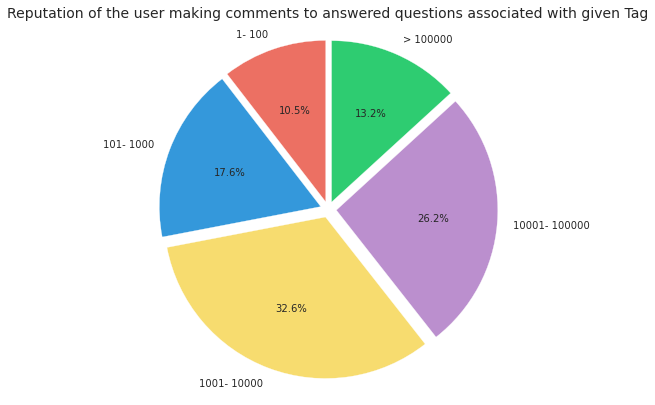

In [192]:
result1 = Reputation_answered('java')
result1

## Function to find reputation of users commenting on Unanswered questions associated with given tag :

In [213]:
def Reputation_unanswered(keyword):
    # Reputation of the user making comments to answered questions for given tag.
    query_unanswered1 = """
    select 
        case
            when uc.reputation between 1 and 100 then '11- 100'
            when uc.reputation between 101 and 1000 then '2101- 1000'
            when uc.reputation between 1001 and 10000 then '31001- 10000'
            when uc.reputation between 10001 and 100000 then '410001- 100000'
            when uc.reputation > 100000 THEN '5> 100000'
        end as Reputation,
        sum(uc.num) as num
    from(    
    select u.reputation, count(*) as num
    from `bigquery-public-data.stackoverflow.users` u
    inner join(
        select c.user_id
        from `bigquery-public-data.stackoverflow.comments` c
        inner join (
            select id from `bigquery-public-data.stackoverflow.posts_questions`
            where answer_count = 0 and tags like '%"""

    query_unanswered2 = keyword

    query_unanswered3 = """%') q
        on post_id = q.id)
    on id = user_id
    group by reputation
    order by reputation asc) uc
    group by Reputation
    order by Reputation
    """
    aggregated = query_unanswered1+query_unanswered2+query_unanswered3
    df_reputation2 = stackoverflow.query_to_pandas(aggregated)
    df_reputation2 = del_order_mark(df_reputation2)
    
    reputation_json2 = df_reputation2.to_json(orient = 'index')
    #print(df_reputation2)
    
#     labels = df_reputation2.Reputation
#     sizes = round(100 * df_reputation2.num / df_reputation2.num.sum(),2)
#     #colors = ['#EC7063','#3498DB','#F7DC6F','#BB8FCE','#2ECC71']
#     colors = ['#AEB6BF', '#A569BD','#CD5C5C', '#F39C12', '#27AE60']
#     explode = (0.05,0.05,0.05,0.05,0.05)

#     fig1, ax1 = plt.subplots()
#     ax1.pie(sizes, colors = colors, labels=labels, autopct='%1.1f%%', startangle=90, explode=explode)
#     ax1.axis('equal')  
#     plt.tight_layout()
#     plt.title("Reputation of the user making comments to unanswered questions associated with given Tag", fontsize = 14)
    
    return reputation_json2    

      Reputation     num
0         1- 100  145109
1      101- 1000  150828
2    1001- 10000  205278
3  10001- 100000  175863
4       > 100000   70007


'{"0":{"Reputation":"1- 100","num":145109},"1":{"Reputation":"101- 1000","num":150828},"2":{"Reputation":"1001- 10000","num":205278},"3":{"Reputation":"10001- 100000","num":175863},"4":{"Reputation":"> 100000","num":70007}}'

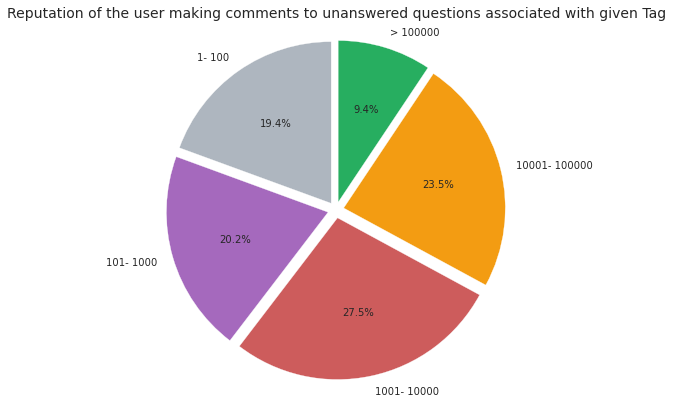

In [214]:
result2 = Reputation_unanswered('python')
result2

## Top 10 MOST Viewed questions in 2020 for given Tag :

In [160]:
def Topviewed_questions(keyword):
    query_topques1 = """SELECT id, title, answer_count answers, favorite_count favs,
                        view_count views, score votes
                        FROM `bigquery-public-data.stackoverflow.posts_questions` 
                        WHERE EXTRACT(YEAR FROM creation_date)= 2020 AND tags like '%"""
    query_topques2 = keyword
    query_topques3 = """%'
                        order by views DESC 
                        LIMIT 10
                        """
    query_topques = query_topques1+query_topques2+query_topques3
    topques = stackoverflow.query_to_pandas(query_topques)
    topques = topques.fillna(0.0)
    topques_JSON = topques.to_json()
    #print(topques)
    return topques_JSON
    

In [161]:
topques = Topviewed_questions('python')
topques

         id                                              title  answers  favs  \
0  59823283  Could not load dynamic library 'cudart64_101.d...        9  15.0   
1  59997065  pip/python: normal site-packages is not writeable        4   6.0   
2  60029215  Warning: pip is being invoked by an old script...        6   5.0   
3  59991397  AttributeError: 'DataFrame' object has no attr...       13   1.0   
4  60229375  Solution for SpecificationError: nested rename...        9   4.0   
5  61678445  Could not build wheels since package wheel is ...        1   0.0   
6  61559359  Could not build wheels for pyaudio, since pack...        2   1.0   
7  61356834  WTForms: Install 'email_validator' for email v...        6   9.0   
8  61893719  ImportError: cannot import name 'joblib' from ...        7   1.0   
9  59711301                      Install PyQt5 5.14.1 on Linux        4   1.0   

   views  votes  
0  76612     48  
1  38599     20  
2  38296     18  
3  33448     30  
4  22606      9  


'{"id":{"0":59823283,"1":59997065,"2":60029215,"3":59991397,"4":60229375,"5":61678445,"6":61559359,"7":61356834,"8":61893719,"9":59711301},"title":{"0":"Could not load dynamic library \'cudart64_101.dll\' on tensorflow CPU-only installation","1":"pip\\/python: normal site-packages is not writeable","2":"Warning: pip is being invoked by an old script wrapper","3":"AttributeError: \'DataFrame\' object has no attribute \'ix\'","4":"Solution for SpecificationError: nested renamer is not supported while agg() along with groupby()","5":"Could not build wheels since package wheel is not installed","6":"Could not build wheels for pyaudio, since package \'wheel\' is not installed","7":"WTForms: Install \'email_validator\' for email validation support","8":"ImportError: cannot import name \'joblib\' from \'sklearn.externals\'","9":"Install PyQt5 5.14.1 on Linux"},"answers":{"0":9,"1":4,"2":6,"3":13,"4":9,"5":1,"6":2,"7":6,"8":7,"9":4},"favs":{"0":15.0,"1":6.0,"2":5.0,"3":1.0,"4":4.0,"5":0.0,"6":

## For notification functionality : Top viewed Questions in general in 2020 :

In [167]:
def Topviewed_general(keyword):
    query_topGen = """SELECT id, title, answer_count answers, favorite_count favs,
                        view_count views, score votes
                        FROM `bigquery-public-data.stackoverflow.posts_questions` 
                        WHERE EXTRACT(YEAR FROM creation_date)= 2020 
                        order by views DESC 
                        LIMIT 10
                        """
    
    topGen = stackoverflow.query_to_pandas(query_topGen)
    topGen = topGen.fillna(0.0)
    topGen_JSON = topGen.to_json()
    print(topGen)
    return topGen_JSON
    

In [168]:
topGen = Topviewed_general('python')
topGen

         id                                              title  answers  favs  \
0  61205390  DevTools failed to load SourceMap: Could not l...        7     6   
1  59763531    Maven dependencies are failing with a 501 error       24    20   
2  60296873  SessionNotCreatedException: Message: session n...       20    12   
3  59823283  Could not load dynamic library 'cudart64_101.d...        9    15   
4  60092642  TS1086: An accessor cannot be declared in ambi...       10     6   
5  60234640  TypeError [ERR_INVALID_ARG_TYPE]: The "path" a...       14    21   
6  60131331  error TS1086: An accessor cannot be declared i...        5     7   
7  59601077  IntelliJ: Error:java: error: release version 5...       14    14   
8  60440509  Android Command line tools sdkmanager always s...       17    30   
9  60174503     Job name "..getProjectMetadata" does not exist       10    15   

    views  votes  
0  110116     16  
1   86902    176  
2   81116     39  
3   76612     48  
4   65288    

'{"id":{"0":61205390,"1":59763531,"2":60296873,"3":59823283,"4":60092642,"5":60234640,"6":60131331,"7":59601077,"8":60440509,"9":60174503},"title":{"0":"DevTools failed to load SourceMap: Could not load content","1":"Maven dependencies are failing with a 501 error","2":"SessionNotCreatedException: Message: session not created: This version of ChromeDriver only supports Chrome version 81","3":"Could not load dynamic library \'cudart64_101.dll\' on tensorflow CPU-only installation","4":"TS1086: An accessor cannot be declared in ambient context","5":"TypeError [ERR_INVALID_ARG_TYPE]: The \\"path\\" argument must be of type string. Received type undefined raised when starting react app","6":"error TS1086: An accessor cannot be declared in an ambient context in Angular 9","7":"IntelliJ: Error:java: error: release version 5 not supported","8":"Android Command line tools sdkmanager always shows: Warning: Could not create settings","9":"Job name \\"..getProjectMetadata\\" does not exist"},"ans